# Stage modelling from spatial features

In [1]:
import os
import numpy as np
import anndata as ad
import pandas as pd
from plotnine import *

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedGroupKFold, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.neighbors import KNeighborsClassifier
import scanpy as sc
from joblib import Parallel, delayed
import warnings, logging

import shap

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Overall cell features

In [2]:
cell_table = pd.read_csv("../../data/cell_table_with_types_stage.csv", 
                         index_col = 0)

/tmp/ipykernel_2625687/1000358550.py:1: DtypeWarning: Columns (39,40,41,42,43,44,45,46,48,49,52,53,54,55,56,57,58,59,60,61,62,63,65,66,68) have mixed types. Specify dtype option on import or set low_memory=False.


In [3]:
metab_markers = ['CA9', 'CD98', 'CytC', 'MCT1', 'ASCT2', 'LDH', 'GS', 'GLS', 'ATP5A', 'CS', 'PKM2', 'GLUT1', 'ARG1', 'CPT1A', 'Ki67']

# Only metabolic markers for cancer/epithelial cells
df = cell_table.loc[cell_table.consensus == "Cancer_cell",metab_markers] 
meta = cell_table.loc[cell_table.consensus == "Cancer_cell",["Stage","fov"]]

# A few FOVs show only few epithelial cells and might only add noise to the analysis
sparse_epi_fovs = meta.fov.value_counts()[meta.fov.value_counts() <= 20].index
df = df.loc[~meta.fov.isin(sparse_epi_fovs)]
meta = meta.loc[~meta.fov.isin(sparse_epi_fovs)]

# Only keep well-annotated cancer stages
epithelial_subset = meta["Stage"].isin(["pT1", "pT2", "pT3", "pT4"]).values

We choose to perform the prediction task on well annotated FOVs with sufficient epithelial cells.
```python
# Note: 13 FOVs are not annotated as healthy or to a specific cancer stage
cell_table.loc[cell_table.fov.isin(meta.loc[~epithelial_subset].fov), "fov"].unique()

# Additionally, 7 FOVs do not contain epithelial cells and are therefore lost
set(cell_table.fov) - set(meta.fov)

# Finally, we also exclude 27 FOVs that contain only few epithelial cells
# The rationale is to compare on the cellular organization around the colorectal epithelium
set(sparse_epi_fovs)
```

In [4]:
# The least represented conditions are mostly unaffected
print(cell_table.groupby("fov").first().Stage.value_counts())
print(meta.loc[epithelial_subset].groupby("fov").first().Stage.value_counts())

Stage
pT3          234
pT4          105
pT2           92
pT1           19
SCT            6
Colon-no.      5
Name: count, dtype: int64
Stage
pT3    218
pT4     97
pT2     85
pT1     18
Name: count, dtype: int64


## Prepare cross-validation

In [5]:
# Define which fovs will be held out for validation (outer loop)
fov_stage_table = meta.loc[epithelial_subset].drop_duplicates().reset_index(drop=True)
fov_inner, fov_val, y_inner, y_val = train_test_split(
    fov_stage_table["fov"], fov_stage_table["Stage"], test_size=0.2, random_state=0, stratify=fov_stage_table["Stage"])
meta["inner"] = meta["fov"].isin(fov_inner)
# For sanity check, the following should consistently be used as validation set
" ".join(fov_val.sort_values())

'A1a A1f A1h A2g A2i A2q A2r A3m A4e A4n A5a A5q A6b A6c A6g A6m A6p A6q A6r A7f A7p A8a A8m A9o A9q B1h B1k B2a B2b B2k B2o B3c B3g B4b B4g B4m B6i B6q B7c B7p B7r B8b B8d B8g B8i B8l B9c B9d B9h B9m B9n B9o C1i C1l C2a C2f C2k C3c C3h C4a C4g C4k C5a C5k C5l C6d C8a C8h D1i D1l D1m D2e D2k D4c D5b D5d D5h D5k D5l D6c D6k D7a D8d D8h'

In [6]:
n_splits = 4

cv_folds = StratifiedGroupKFold(n_splits=n_splits)
for train, test in cv_folds.split(df.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]],
                                  meta.loc[epithelial_subset].loc[meta["inner"]]["Stage"],
                                  groups=meta.loc[epithelial_subset].loc[meta["inner"]]["fov"]):
    # All stages should be present in both train and test
    assert len(meta.loc[epithelial_subset].loc[meta["inner"]].iloc[test].groupby("fov")["Stage"].first().unique()) == 4
    assert len(meta.loc[epithelial_subset].loc[meta["inner"]].iloc[train].groupby("fov")["Stage"].first().unique()) == 4
    # Print the first test FOVs
    print(meta.loc[epithelial_subset].loc[meta["inner"]].iloc[test].groupby("fov").first().index[:5]) 

Index(['A1e', 'A1n', 'A3b', 'A3d', 'A3e'], dtype='object', name='fov')
Index(['A1c', 'A1m', 'A1o', 'A1p', 'A1q'], dtype='object', name='fov')
Index(['A1l', 'A1r', 'A2b', 'A2c', 'A2l'], dtype='object', name='fov')
Index(['A1d', 'A1i', 'A1k', 'A2a', 'A2d'], dtype='object', name='fov')


We can split the data at the cell level to allow applications that involve processing single cells. The grouping ensures that the data is split per FOV without contamination (i.e. cells from a given FOV present both in training and testing).

In [7]:
meta
meta_per_fov = meta.loc[epithelial_subset].groupby("fov").first()

In [8]:
df_per_fov = df.copy()
df_per_fov["fov"] = meta["fov"] 
df_per_fov = df_per_fov.loc[epithelial_subset].groupby("fov").mean()
meta_per_fov = meta.loc[epithelial_subset].groupby("fov").first()

Alternatively, we directly split the FOVs, for applications that involve FOV-level features. 
Note: we could generate independent folds, but the FOV distribution would not be identical.
We choose to directly define the folds to be the same to make results more comparable.
```Python
cv_folds_fov = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2020)
for train, test in cv_folds_fov.split(df_per_fov.loc[meta_per_fov["inner"]],
                                      meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]
                                    ):
    # All stages should be present in both train and test
    assert len(meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"].unique()) == 5
    assert len(meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"].unique()) == 5
    # Print the first test FOVs
    print(meta_per_fov.loc[meta_per_fov["inner"]].iloc[test].index[:5]) 

```

In [9]:
def conv_traintest_cells_to_fov():
    for train, test in cv_folds.split(df.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]],
                                    meta.loc[epithelial_subset].loc[meta["inner"]]["Stage"],
                                    groups=meta.loc[epithelial_subset].loc[meta["inner"]]["fov"]):
        test_fovs = meta.loc[epithelial_subset].loc[meta["inner"]].iloc[test].groupby("fov").first().index
        train_fovs = meta.loc[epithelial_subset].loc[meta["inner"]].iloc[train].groupby("fov").first().index
        test_fovs_ind = np.where(meta_per_fov.loc[meta_per_fov["inner"]].index.isin(test_fovs))[0]
        train_fovs_ind = np.where(meta_per_fov.loc[meta_per_fov["inner"]].index.isin(train_fovs))[0]
        yield (train_fovs_ind, test_fovs_ind)

# Should work as the output of `split` method: two arrays of indices
cv_folds_fov = [x for x in conv_traintest_cells_to_fov()]

for train, test in cv_folds_fov:
    # All stages should be present in both train and test
    assert len(meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"].unique()) == 4
    assert len(meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"].unique()) == 4
    # Print the first test FOVs
    print(meta_per_fov.loc[meta_per_fov["inner"]].iloc[test].index[:5])

Index(['A1e', 'A1n', 'A3b', 'A3d', 'A3e'], dtype='object', name='fov')
Index(['A1c', 'A1m', 'A1o', 'A1p', 'A1q'], dtype='object', name='fov')
Index(['A1l', 'A1r', 'A2b', 'A2c', 'A2l'], dtype='object', name='fov')
Index(['A1d', 'A1i', 'A1k', 'A2a', 'A2d'], dtype='object', name='fov')


## Model 0: Baseline (most abundant label)

In [10]:
np.mean([f1_score(LabelEncoder().fit_transform(meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"]),
                [2 for _ in range(meta_per_fov.loc[meta_per_fov["inner"]].iloc[test].shape[0])],
                average="macro")
                for train, test in cv_folds_fov])

0.17126558017457122

In [11]:
for train, test in cv_folds_fov:
    y_train = meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"]
    y_test = meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"]
    
    le = LabelEncoder()
    baseline_f1_scores = [f1_score(
                            le.fit_transform(y_test),
                            np.random.randint(0,5,y_test.shape[0]),
                            average="macro")
                        for _ in range(1000)]
    print(f"Baseline: {np.median(baseline_f1_scores)} (95% CI: {np.percentile(baseline_f1_scores, 2.5)}-{np.percentile(baseline_f1_scores, 97.5)})")
baseline_f1 = np.median(baseline_f1_scores)

Baseline: 0.15093898587751048 (95% CI: 0.08724529244447916-0.22558875643280568)
Baseline: 0.15507469182302697 (95% CI: 0.0849370334438246-0.2213420767955473)
Baseline: 0.15408483134798923 (95% CI: 0.09374144663985544-0.22621138948770528)
Baseline: 0.1518564440868151 (95% CI: 0.08835290043356538-0.2250015664160401)


In [12]:
np.random.seed(0)
all_f1_scores = []
for train, test in cv_folds_fov:
    y_train = meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"]
    y_test = meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"]
    
    le = LabelEncoder()
    baseline_f1_scores = [f1_score(
                            le.fit_transform(y_test),
                            le.transform(np.random.choice(y_train, len(y_test), replace=True)),
                            average="macro")
                        for _ in range(1000)]
    print(f"Baseline: {np.median(baseline_f1_scores)} (95% CI: {np.percentile(baseline_f1_scores, 2.5)}-{np.percentile(baseline_f1_scores, 97.5)})")
    all_f1_scores.append(baseline_f1_scores)
# Expectation of performance across all folds
all_f1_scores = np.array(all_f1_scores)
print(f"Baseline: {np.median(np.median(all_f1_scores, axis=0))} (95% CI: {np.mean(np.percentile(all_f1_scores, 2.5, axis=0))}-{np.mean(np.percentile(all_f1_scores, 97.5, axis=0))})")
baseline_f1 = np.median(all_f1_scores)

Baseline: 0.24373377399740384 (95% CI: 0.16763731365293866-0.35463332634318406)
Baseline: 0.244611038133318 (95% CI: 0.16527132740447958-0.3361897730545976)
Baseline: 0.2427863219637999 (95% CI: 0.1708228348669525-0.3521886051884862)
Baseline: 0.24461319016703584 (95% CI: 0.16653414312799256-0.35216117385458157)
Baseline: 0.24477415871808744 (95% CI: 0.20491236573613264-0.29433320577147765)


## Model 1: Cell type composition

In [13]:
cell_type_proportions = cell_table.groupby("fov")["consensus"].value_counts().unstack().fillna(0)
# Normalize by the number of cells in each FOV
cell_type_proportions = cell_type_proportions.div(cell_type_proportions.sum(axis=1), axis=0)
# Match to metadata and kept FOVs
cell_type_proportions = cell_type_proportions.loc[meta_per_fov.index]

We could give more weight to rarer classes, but in practice this did not improve performance on inner folds nor reduce overfitting across models.
```python
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=LabelEncoder().fit_transform(meta_per_fov.loc[meta_per_fov["inner"]]["Stage"])
)
scores = cross_val_score(
    XGBClassifier(
        n_estimators=250, 
        max_depth=3, 
        device="cuda", 
        random_state=0),
    cell_type_proportions.loc[meta_per_fov["inner"]],
    LabelEncoder().fit_transform(meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]),
    cv=cv_folds_fov, 
    # params={'sample_weight':sample_weights},
    scoring='f1_macro')
np.mean(scores)
# And later in direct model training
xgb.fit(train_composition,
        LabelEncoder().fit_transform(train_meta),
        # sample_weight=sample_weights[train]
        )
```

In [14]:
scores = cross_val_score(
    XGBClassifier(
        n_estimators=250, 
        max_depth=3, 
        device="cuda", 
        random_state=0),
    cell_type_proportions.loc[meta_per_fov["inner"]],
    LabelEncoder().fit_transform(meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]),
    cv=cv_folds_fov, 
    scoring='f1_macro')
np.mean(scores)

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:14:12] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



0.2703869209035381

For cell type composition, XGBoost seems appropriate (good performance, and in practice a bit more stable than RF, although slower).
```Python
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Define models and their hyperparameters
models = {
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'SVM': SVC(),
    'LogisticRegression': LogisticRegression()
}

params = {
    'RandomForest': {
        'n_estimators': [20, 50, 100, 200, 300],
        'max_depth': [2, 3, 5]
    },
    'XGBoost': {
        'n_estimators': [20, 50, 100, 200, 300],
        'max_depth': [2, 3, 5],
        'device': ['cuda'],
        'random_state': [0]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'LogisticRegression': {
        'C': [0.1, 1, 10],
        'solver': ['lbfgs']
    }
}

# Perform GridSearchCV for each model
best_models = {}
best_scores = {}
for model_name in models:
    grid_search = GridSearchCV(models[model_name], params[model_name], cv=cv_folds_fov, scoring='f1_macro')
    grid_search.fit(cell_type_proportions.loc[meta_per_fov["inner"]], 
                    LabelEncoder().fit_transform(meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]),
                    sample_weight=sample_weights)
    best_models[model_name] = grid_search.best_estimator_
    best_scores[model_name] = grid_search.best_score_

# Print the best models and their parameters
for model in best_models.keys():
    print(model, best_models[model])
    print("Best score:", best_scores[model])
```

In [15]:
def process_fold_composition(train, test, n_estimators = 250, n_depth = 4):
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    with warnings.catch_warnings(action="ignore"):      
        # Step 1: Define train and test subsets of the compositional data
        train_composition = cell_type_proportions.loc[meta_per_fov["inner"]].iloc[train]
        test_composition = cell_type_proportions.loc[meta_per_fov["inner"]].iloc[test]
        train_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"]
        test_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"]

        # Step 2: Train a classifier on the training data composition to predict the stage of each FOV
        xgb = XGBClassifier(
            n_estimators=n_estimators, 
            max_depth=n_depth, 
            device="cuda", 
            random_state=0)
        xgb.fit(train_composition,
                LabelEncoder().fit_transform(train_meta),
                )

        # Step 3: Predict stage of each FOV in the test data
        preds = xgb.predict(test_composition)

        # Step 4: Compute f1_score
        score = f1_score(LabelEncoder().fit_transform(test_meta), 
                        preds, 
                        average="macro")
        return score

In [16]:
def test_estimator_composition(estimators, depth=4):
    scores = [process_fold_composition(train, test, n_estimators=estimators, n_depth=depth)
              for train, test in cv_folds_fov]
    mean_score = np.median(scores)
    # Append to f1 score log file
    with open(f"../../data/model1_cell_composition_f1_scores.txt", "a") as f:
        f.write(f"{estimators},{depth},{mean_score}\n")
    
    print(estimators, depth, mean_score)
    return mean_score

In [141]:
# Parallelize the hyperparameter loop | ~81mn
np.random.seed(0)
estimator_range = np.arange(15, 511, 10)
depth_range = np.arange(3, 10, 2)
estimator_range, depth_range = np.meshgrid(estimator_range, depth_range)
Parallel(n_jobs=28)(delayed(test_estimator_composition)(r_estimators, r_depth)
                for r_estimators, r_depth in zip(estimator_range.ravel(), depth_range.ravel()))

KeyboardInterrupt: 

In [17]:
pd.read_csv("../../data/model1_cell_composition_f1_scores.txt", header=None, names=["estimators", "depth", "score"]).sort_values("score", ascending=False).head(10)

,estimators,depth,score
227,15,5,0.295036
25,15,5,0.295036
162,455,7,0.294420
171,505,7,0.294420
167,485,7,0.294420
170,495,7,0.294420
364,455,7,0.294420
103,145,7,0.290464
305,145,7,0.290464
316,195,7,0.289334


In [18]:
# Table used to score inner fold scores for all models
all_models_inner = pd.DataFrame(columns=["model", "score"])
# Compute scores for this model
scores = [process_fold_composition(train, test, n_estimators=15, n_depth=5)
              for train, test in cv_folds_fov]

print(np.median(scores))
# Add the model
all_models_inner = pd.concat([all_models_inner, 
                            pd.DataFrame({
                                "model": ["M1 composition" for _ in enumerate(scores)],
                                "score": scores
                            })], ignore_index=True)

0.2950358422939068


### SHAP analysis

[[ 14   0   0   0]
 [  0  68   0   0]
 [  0   0 174   0]
 [  0   0   0  78]]


/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 7 x 5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig2/compo_importance_correctly_predicted_samples.pdf


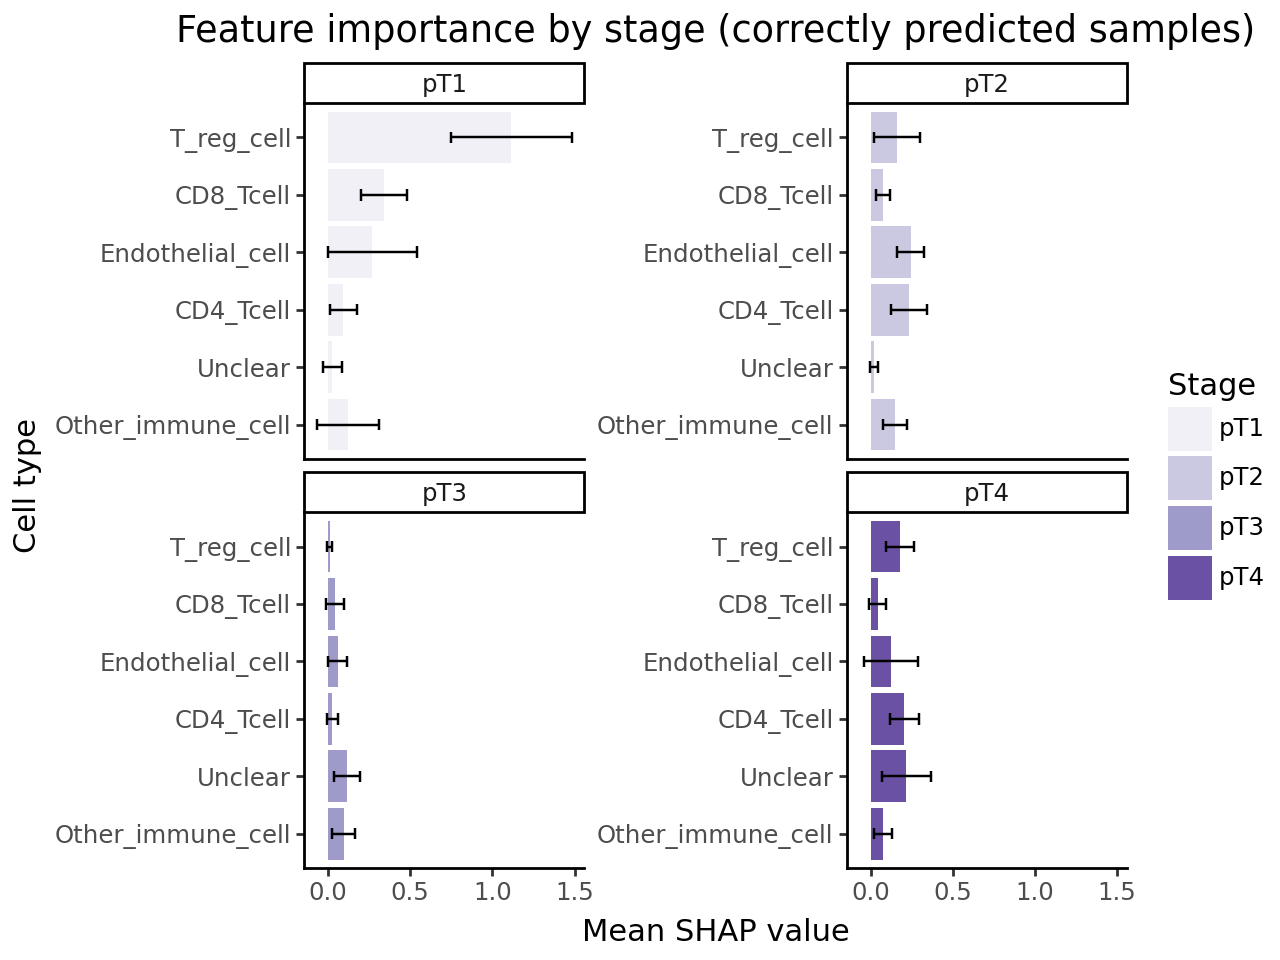

In [19]:
FT_PER_CLASS = 2 # Number of most important features kept per class

train_fov = cell_type_proportions.loc[meta_per_fov["inner"]]
original_stages = meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(original_stages)

xgb = XGBClassifier(
    n_estimators=15, 
    max_depth=5, 
    device="cuda", 
    random_state=0)
xgb.fit(train_fov,
        true_labels)

explainer = shap.Explainer(xgb)
shap_values = explainer(train_fov)

# Purples
pal_stages = [(242,240,247), (203,201,226), (158,154,201), (106,81,163)]
# Convert to hex
pal_stages = ['#%02x%02x%02x' % (r, g, b) for r, g, b in pal_stages]

predicted_labels = xgb.predict(train_fov)
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)
# Few errors on training set, so not meaningful to interpret misclassified FOVs

# For each stage, see how the true positive samples were predicted (SHAP values)

# Get indices of correctly predicted samples for each class
correct_indices = {class_idx: np.where((true_labels == class_idx) & (predicted_labels == class_idx))[0] 
                   for class_idx in range(conf_matrix.shape[0])}

shap_values_list = []
for class_idx, indices in correct_indices.items():
    shap_values_class = pd.DataFrame(shap_values.values[indices, :, class_idx], 
                                     columns=train_fov.columns)
    shap_values_class['fov'] = train_fov.index[indices]
    shap_values_class['class'] = label_encoder.inverse_transform([class_idx])[0]  # Use original stage names
    shap_values_list.append(shap_values_class)

shap_values_df = pd.concat(shap_values_list)

# Melt the DataFrame for easier plotting with plotnine
shap_values_melted = shap_values_df.melt(id_vars=['fov', 'class'], var_name='Feature', value_name='SHAP Value')

# Compute mean and std SHAP values for feature importance for each class
feature_importance = shap_values_melted.groupby(['class', 'Feature'])['SHAP Value'].agg(['mean', 'std']).reset_index()
# We want to display either high positive or high negative values
feature_importance["abs_mean"] = np.abs(feature_importance["mean"]) 
feature_importance = feature_importance.sort_values(by=['class', 'abs_mean'], ascending=[True, False])

# Note: nothing enforces SHAP values to be positive, but in average they all seem to be

feature_importance = feature_importance.loc[feature_importance.Feature.isin(feature_importance.groupby('class').head(FT_PER_CLASS).Feature)]

# Add a column for reordering features
feature_importance['Feature'] = pd.Categorical(feature_importance['Feature'], 
                                               categories=feature_importance.groupby('class').head(FT_PER_CLASS).Feature.unique()[::-1], 
                                               ordered=True)
feature_importance['class'] = feature_importance['class'].astype('category')

# Step 8: Visualize feature importance using plotnine
gp = (ggplot(feature_importance, 
                aes(x='Feature', y='mean', fill='class'))
      + geom_bar(stat='identity', position='dodge')
      + geom_errorbar(aes(ymin='mean-0.5*std', ymax='mean+0.5*std'), width=0.2, position='dodge')
      + coord_flip()
      + theme_classic()
      + scale_fill_manual(values=pal_stages)
      + labs(title='Feature importance by stage (correctly predicted samples)', x='Cell type', y='Mean SHAP value', fill='Stage')
      + facet_wrap('~class', scales='free_y'))

ggsave(gp, "../../figures/fig2/compo_importance_correctly_predicted_samples.pdf", width=7, height=5)

gp.show()


## Model 2: Metabolic intensities
See *MetabViz.ipynb* for details.

In [20]:
pd.read_csv("../../data/model2_metab_markers_f1_scores.txt", names = ["estimators", "depth", "score"]).sort_values("score", ascending=False).head(10)

,estimators,depth,score
0,15,3,0.287336
33,305,3,0.275632
24,255,3,0.274708
26,265,3,0.272072
21,225,3,0.271949
20,215,3,0.271949
16,175,3,0.271719
22,235,3,0.271641
37,325,3,0.270650
35,315,3,0.270650


In [21]:
df_per_fov = df.copy()
df_per_fov["fov"] = meta["fov"] 
df_per_fov = df_per_fov.loc[epithelial_subset].groupby("fov")
df_per_fov = df_per_fov.mean().join(df_per_fov.std(), rsuffix="_std")

In [22]:
def process_fold_intensities(train, test, n_estimators = 250, n_depth = 4):
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    with warnings.catch_warnings(action="ignore"):      
        # Step 1: Define train and test subsets of the compositional data
        train_func = df_per_fov.loc[meta_per_fov["inner"]].iloc[train]
        test_func = df_per_fov.loc[meta_per_fov["inner"]].iloc[test]
        train_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"]
        test_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"]

        # Step 2: Train a classifier on the training data composition to predict the stage of each FOV
        xgb = XGBClassifier(
            n_estimators=n_estimators, 
            max_depth=n_depth, 
            device="cuda", 
            random_state=0)
        xgb.fit(train_func,
                LabelEncoder().fit_transform(train_meta))

        # Step 3: Predict stage of each FOV in the test data
        preds = xgb.predict(test_func)

        # Step 4: Compute f1_score
        score = f1_score(LabelEncoder().fit_transform(test_meta), 
                        preds, 
                        average="macro")
        return score

In [23]:
scores = [process_fold_intensities(train, test, n_estimators=15, n_depth=3)
              for train, test in cv_folds_fov]
print(np.median(scores))

0.2873355500237963


In [24]:
# Add the model
all_models_inner = pd.concat([all_models_inner, 
                            pd.DataFrame({
                                "model": ["M2 metabolic markers" for _ in enumerate(scores)],
                                "score": scores
                            })], ignore_index=True)

## Model 3: Functional features

In [25]:
func_features = ["STING1", "Ki67", "MSH2", "MSH6", "PDL1"]

# We start by looking at the cell shape of cancer cells
df_func = cell_table.loc[cell_table.consensus == "Cancer_cell",func_features] 
# df_morpho.index = df_morpho.index.astype(str)
df_func = df_func.loc[meta.index].loc[epithelial_subset]
df_func["fov"] = meta.loc[epithelial_subset]["fov"]
# For mean and std
df_func_per_fov = df_func.groupby("fov").mean().join(df_func.groupby("fov").std(), rsuffix="_std")

assert meta_per_fov.index.equals(df_func_per_fov.index)

In [26]:
cross_val_score(
    XGBClassifier(
        n_estimators=100, 
        max_depth=3, 
        device="cuda", 
        random_state=0),
    df_func_per_fov.loc[meta_per_fov["inner"]],
    LabelEncoder().fit_transform(meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]),
    cv=cv_folds_fov, 
    scoring='f1_macro')

array([0.28074773, 0.25196327, 0.19044248, 0.26632035])

In [27]:
def process_fold_func(train, test, n_estimators = 250, n_depth = 4):
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    with warnings.catch_warnings(action="ignore"):      
        # Step 1: Define train and test subsets of the compositional data
        train_func = df_func_per_fov.loc[meta_per_fov["inner"]].iloc[train]
        test_func = df_func_per_fov.loc[meta_per_fov["inner"]].iloc[test]
        train_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"]
        test_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"]

        # Step 2: Train a classifier on the training data composition to predict the stage of each FOV
        xgb = XGBClassifier(
            n_estimators=n_estimators, 
            max_depth=n_depth, 
            device="cuda", 
            random_state=0)
        xgb.fit(train_func,
                LabelEncoder().fit_transform(train_meta))

        # Step 3: Predict stage of each FOV in the test data
        preds = xgb.predict(test_func)

        # Step 4: Compute f1_score
        score = f1_score(LabelEncoder().fit_transform(test_meta), 
                        preds, 
                        average="macro")
        return score

In [28]:
def test_estimator_func(estimators, depth):
    scores = [process_fold_func(train, test, n_estimators=estimators, n_depth=depth)
              for train, test in cv_folds_fov]
    mean_score = np.median(scores)
    # Append to f1 score log file
    with open(f"../../data/model6_functional_markers_f1_scores.txt", "a") as f:
        f.write(f"{estimators},{depth},{mean_score}\n")
    
    print(estimators, depth, mean_score)
    return mean_score

In [ ]:
# Parallelize the hyperparameter loop | ~ 30mn
estimator_range = np.arange(15, 511, 10)
depth_range = np.arange(3, 10, 2)
estimator_range, depth_range = np.meshgrid(estimator_range, depth_range)
Parallel(n_jobs=16)(delayed(test_estimator_func)(r_estimators, r_depth)
                for r_estimators, r_depth in zip(estimator_range.ravel(), depth_range.ravel()));

15 3 0.23664125923314466
25 3 0.2486274991805965
35 3 0.24080971000325838
45 3 0.2674062049062049
55 3 0.25525861443033776
65 3 0.2530580735024698
75 3 0.24988336894586893
85 3 0.26010776120297147
95 3 0.2549412709501834
105 3 0.25041458903408914
115 3 0.2549412709501834
125 3 0.2549412709501834
135 3 0.26645782339415514
145 3 0.2756645751595329
155 3 0.2657303270177376
165 3 0.26845185067913074
175 3 0.27078461170056
185 3 0.2736977006993772
195 3 0.27403044173205465
205 3 0.2692199209840339
215 3 0.2692199209840339
225 3 0.26948710899315736
235 3 0.2509470512268618
245 3 0.24870149602618044
255 3 0.2509470512268618
265 3 0.2509470512268618
275 3 0.2509470512268618
285 3 0.2509470512268618
295 3 0.2537709086633154
305 3 0.2537709086633154
315 3 0.2537709086633154
325 3 0.2537709086633154
335 3 0.25342229875161426
345 3 0.25343637532819085
355 3 0.2509611278034384
15 5 0.2483596607328859
365 3 0.2507514813981398
25 5 0.2598577348577349
375 3 0.2527804417320546
35 5 0.2605535624508488
3

In [29]:
pd.read_csv("../../data/model6_functional_markers_f1_scores.txt", 
            header=None, 
            names=["estimators", "depth", "score"]).sort_values("score", ascending=False).head(10)

,estimators,depth,score
13,145,3,0.275665
18,195,3,0.274030
17,185,3,0.273698
16,175,3,0.270785
21,225,3,0.269487
19,205,3,0.269220
20,215,3,0.269220
15,165,3,0.268452
3,45,3,0.267406
12,135,3,0.266458


In [30]:
scores = [process_fold_func(train, test, n_estimators=145, n_depth=3)
              for train, test in cv_folds_fov]
print(np.median(scores))
# Add the model
all_models_inner = pd.concat([all_models_inner, 
                            pd.DataFrame({
                                "model": ["M3 functional markers" for _ in enumerate(scores)],
                                "score": scores
                            })], ignore_index=True)

0.2756645751595329


## Model 4: Morphological features

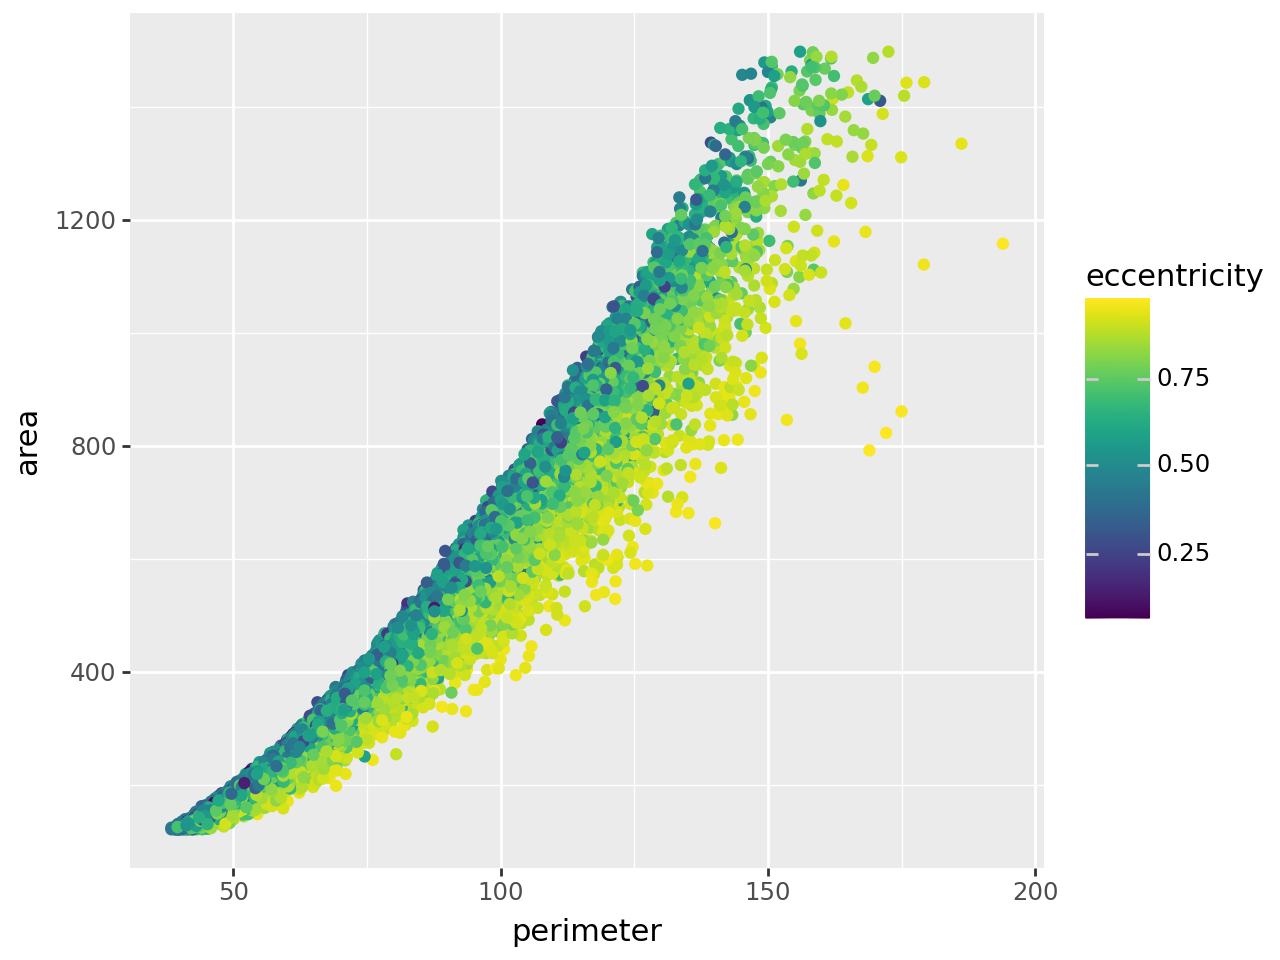

In [31]:
# Information appears correlated but complementary
ggplot(cell_table.sample(20000), aes(x = 'perimeter', y = 'area', color = 'eccentricity')) + geom_point()

In [32]:
morpho_features = ['eccentricity', 'perimeter', 'area']

# We start by looking at the cell shape of cancer cells
df_morpho = cell_table.loc[cell_table.consensus == "Cancer_cell",morpho_features] 
# df_morpho.index = df_func.index.astype(str)
df_morpho = df_morpho.loc[meta.index].loc[epithelial_subset]
df_morpho["fov"] = meta.loc[epithelial_subset]["fov"]
# For mean and std
df_morpho_per_fov = df_morpho.groupby("fov").mean().join(df_morpho.groupby("fov").std(), rsuffix="_std")

assert meta_per_fov.index.equals(df_morpho_per_fov.index)

In [33]:
cross_val_score(
    XGBClassifier(
        n_estimators=100, 
        max_depth=3, 
        device="cuda", 
        random_state=0),
    df_morpho_per_fov.loc[meta_per_fov["inner"]],
    LabelEncoder().fit_transform(meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]),
    cv=cv_folds_fov, 
    scoring='f1_macro')

array([0.26818182, 0.25925282, 0.28821945, 0.28854915])

In [34]:
def process_fold_morphology(train, test, n_estimators = 250, n_depth = 4):
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    with warnings.catch_warnings(action="ignore"):      
        # Step 1: Define train and test subsets of the compositional data
        train_morphology = df_morpho_per_fov.loc[meta_per_fov["inner"]].iloc[train]
        test_morphology = df_morpho_per_fov.loc[meta_per_fov["inner"]].iloc[test]
        train_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"]
        test_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"]

        # Step 2: Train a classifier on the training data composition to predict the stage of each FOV
        xgb = XGBClassifier(
            n_estimators=n_estimators, 
            max_depth=n_depth, 
            device="cuda", 
            random_state=0)
        xgb.fit(train_morphology,
                LabelEncoder().fit_transform(train_meta))

        # Step 3: Predict stage of each FOV in the test data
        preds = xgb.predict(test_morphology)

        # Step 4: Compute f1_score
        score = f1_score(LabelEncoder().fit_transform(test_meta), 
                        preds, 
                        average="macro")
        return score

In [35]:
def test_estimator_morphology(estimators, depth):
    scores = [process_fold_morphology(train, test, n_estimators=estimators, n_depth=depth)
              for train, test in cv_folds_fov]
    mean_score = np.median(scores)
    # Append to f1 score log file
    with open(f"../../data/model5_cell_morphology_f1_scores.txt", "a") as f:
        f.write(f"{estimators},{depth},{mean_score}\n")
    
    print(estimators, depth, mean_score)
    return mean_score

In [ ]:
# Parallelize the hyperparameter loop | ~ 30mn
estimator_range = np.arange(15, 511, 10)
depth_range = np.arange(3, 10, 2)
estimator_range, depth_range = np.meshgrid(estimator_range, depth_range)
Parallel(n_jobs=28)(delayed(test_estimator_morphology)(r_estimators, r_depth)
                for r_estimators, r_depth in zip(estimator_range.ravel(), depth_range.ravel()))

15 3 0.24916529229662981
25 3 0.23692958820704596
35 3 0.25126413908671974
45 3 0.2485650052401872
55 3 0.26587705171363873
65 3 0.265930171419614
75 3 0.2681568431568432
85 3 0.2690489596830544
95 3 0.28124826101426537
105 3 0.26942657054268937
115 3 0.2696825444609871
125 3 0.2647860413795011
135 3 0.265358311698941
145 3 0.2727973983661547
155 3 0.2874589490968801
165 3 0.28951140548300514
175 3 0.29268392636542107
185 3 0.29268392636542107
195 3 0.2878871090770404
205 3 0.2809983038914491
215 3 0.2843890351839661
225 3 0.2781390351839661
235 3 0.28680747677944324
245 3 0.2807099158038335
255 3 0.27891116150830086
15 5 0.2433397258893754
265 3 0.2761075190273703
275 3 0.27605827853868165
25 5 0.27590404582885786
285 3 0.27605827853868165
295 3 0.27605827853868165
35 5 0.2628552655820779
45 5 0.2689953359724767
305 3 0.2787820591842938
55 5 0.2700271094154073
315 3 0.27321358640260174
65 5 0.2680339264815027
325 3 0.27321358640260174
75 5 0.2680339264815027
335 3 0.27321358640260174


[0.24916529229662981,
 0.23692958820704596,
 0.25126413908671974,
 0.2485650052401872,
 0.26587705171363873,
 0.265930171419614,
 0.2681568431568432,
 0.2690489596830544,
 0.28124826101426537,
 0.26942657054268937,
 0.2696825444609871,
 0.2647860413795011,
 0.265358311698941,
 0.2727973983661547,
 0.2874589490968801,
 0.28951140548300514,
 0.29268392636542107,
 0.29268392636542107,
 0.2878871090770404,
 0.2809983038914491,
 0.2843890351839661,
 0.2781390351839661,
 0.28680747677944324,
 0.2807099158038335,
 0.27891116150830086,
 0.2761075190273703,
 0.27605827853868165,
 0.27605827853868165,
 0.27605827853868165,
 0.2787820591842938,
 0.27321358640260174,
 0.27321358640260174,
 0.27321358640260174,
 0.2734980878909106,
 0.2736903955832183,
 0.2739035087719298,
 0.2807152076430748,
 0.2807152076430748,
 0.2807152076430748,
 0.2807152076430748,
 0.2807152076430748,
 0.2807152076430748,
 0.2807152076430748,
 0.2870465084560829,
 0.2870465084560829,
 0.2870465084560829,
 0.2870465084560829

In [36]:
pd.read_csv("../../data/model5_cell_morphology_f1_scores.txt", header=None, names=["estimators", "depth", "score"]).sort_values("score", ascending=False).head(10)

,estimators,depth,score
124,15,9,0.295753
143,95,9,0.294646
17,185,3,0.292684
16,175,3,0.292684
72,505,3,0.292664
140,85,9,0.292090
70,495,3,0.291936
135,65,9,0.290972
138,75,9,0.290887
61,185,5,0.290812


In [37]:
scores = [process_fold_morphology(train, test, n_estimators=15, n_depth=9)
              for train, test in cv_folds_fov]
print(np.median(scores))
# Add the model
all_models_inner = pd.concat([all_models_inner, 
                            pd.DataFrame({
                                "model": ["M4 morphology" for _ in enumerate(scores)],
                                "score": scores
                            })], ignore_index=True)

0.2957532977067383


### SHAP analysis

[[ 14   0   0   0]
 [  0  68   0   0]
 [  0   0 174   0]
 [  0   0   0  78]]


/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 7 x 5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig4/morpho_importance_correctly_predicted_samples.pdf


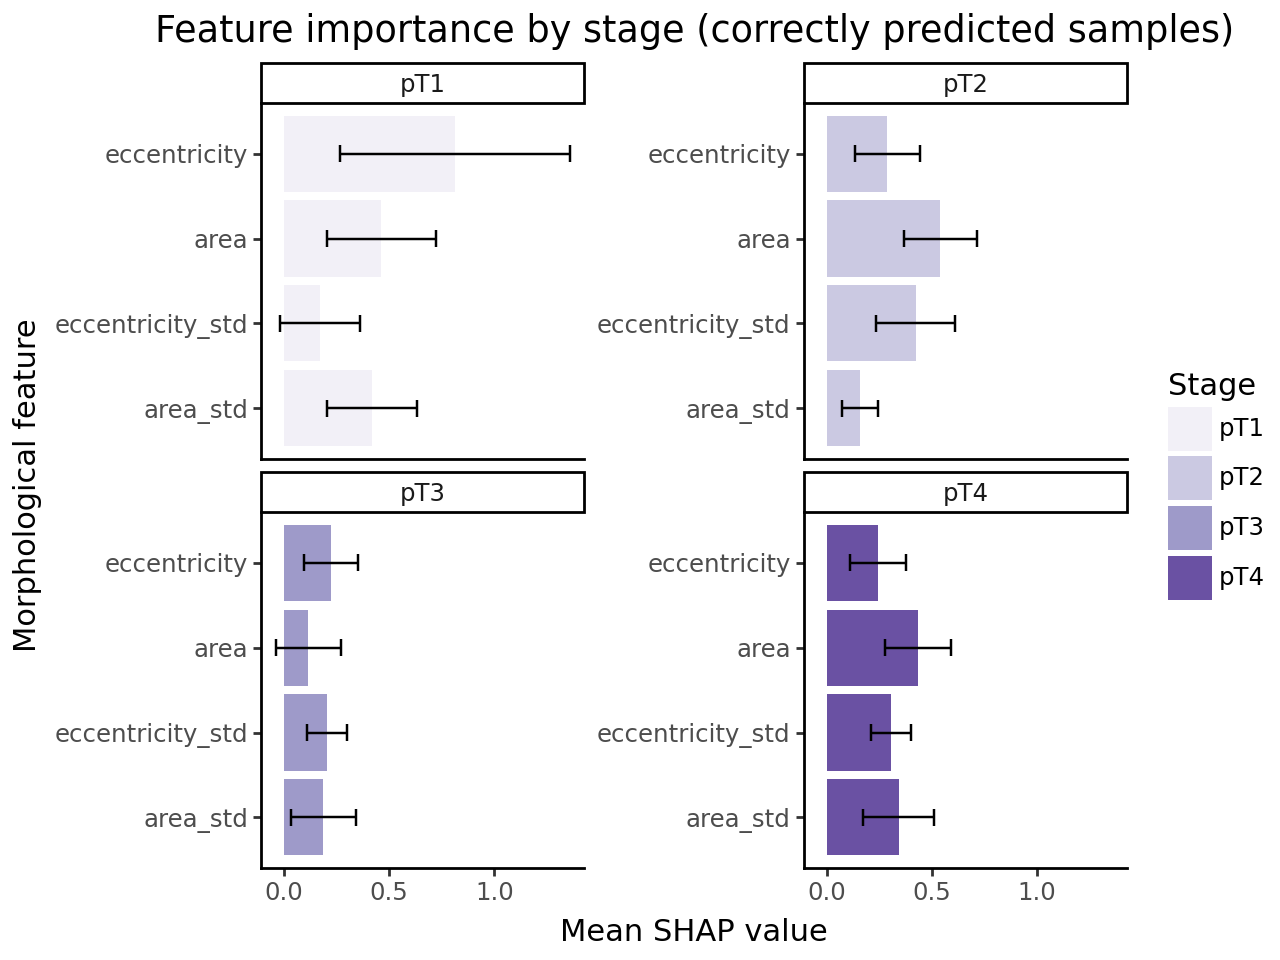

In [38]:
FT_PER_CLASS = 2 # Number of most important features kept per class

train_fov = df_morpho_per_fov.loc[meta_per_fov["inner"]]
original_stages = meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(original_stages)

xgb = XGBClassifier(
    n_estimators=15, 
    max_depth=9, 
    device="cuda", 
    random_state=0)
xgb.fit(train_fov,
        true_labels)

explainer = shap.Explainer(xgb)
shap_values = explainer(train_fov)

# Purples + Green for healthy
pal_stages = [(242,240,247), (203,201,226), (158,154,201), (106,81,163)]
# Convert to hex
pal_stages = ['#%02x%02x%02x' % (r, g, b) for r, g, b in pal_stages]

predicted_labels = xgb.predict(train_fov)
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)
# Few errors on training set, so not meaningful to interpret misclassified FOVs

# For each stage, see how the true positive samples were predicted (SHAP values)

# Get indices of correctly predicted samples for each class
correct_indices = {class_idx: np.where((true_labels == class_idx) & (predicted_labels == class_idx))[0] 
                   for class_idx in range(conf_matrix.shape[0])}

shap_values_list = []
for class_idx, indices in correct_indices.items():
    shap_values_class = pd.DataFrame(shap_values.values[indices, :, class_idx], 
                                     columns=train_fov.columns)
    shap_values_class['fov'] = train_fov.index[indices]
    shap_values_class['class'] = label_encoder.inverse_transform([class_idx])[0]  # Use original stage names
    shap_values_list.append(shap_values_class)

shap_values_df = pd.concat(shap_values_list)

# Melt the DataFrame for easier plotting with plotnine
shap_values_melted = shap_values_df.melt(id_vars=['fov', 'class'], var_name='Feature', value_name='SHAP Value')

# Compute mean and std SHAP values for feature importance for each class
feature_importance = shap_values_melted.groupby(['class', 'Feature'])['SHAP Value'].agg(['mean', 'std']).reset_index()
# We want to display either high positive or high negative values
feature_importance["abs_mean"] = np.abs(feature_importance["mean"]) 
feature_importance = feature_importance.sort_values(by=['class', 'abs_mean'], ascending=[True, False])
feature_importance = feature_importance.loc[feature_importance.Feature.isin(feature_importance.groupby('class').head(FT_PER_CLASS).Feature)]

# Add a column for reordering features
feature_importance['Feature'] = pd.Categorical(feature_importance['Feature'], 
                                               categories=feature_importance.groupby('class').head(FT_PER_CLASS).Feature.unique()[::-1], 
                                               ordered=True)
feature_importance['class'] = feature_importance['class'].astype('category')

# Step 8: Visualize feature importance using plotnine
gp = (ggplot(feature_importance, 
                aes(x='Feature', y='mean', fill='class'))
      + geom_bar(stat='identity', position='dodge')
      + geom_errorbar(aes(ymin='mean-0.5*std', ymax='mean+0.5*std'), width=0.2, position='dodge')
      + coord_flip()
      + theme_classic()
      + scale_fill_manual(values=pal_stages)
      + labs(title='Feature importance by stage (correctly predicted samples)', x='Morphological feature', y='Mean SHAP value', fill='Stage')
      + facet_wrap('~class', scales='free_y'))

ggsave(gp, "../../figures/fig4/morpho_importance_correctly_predicted_samples.pdf", width=7, height=5)

gp.show()

In principle, we could as well look at the morphology of other cell types in the TME. However, this would require to make a lot of choices, as the FOVs with enough cells might not be the same, leading to non-trivial comparisons.

```Python
cells_per_fov = cell_table.groupby("fov").consensus.value_counts().unstack()
# Count NAs per type
cells_per_fov.isna().sum(axis="rows")
# We can also look at the morphology of CAF, NK_cell, CD4_Tcell, Monocyte,
# Endothelial_cell, Other_immune_cell

# morpho_features = ['eccentricity', 'perimeter', 'area']

# We now look at the cell shape of fibroblast cells
df_morpho = cell_table.loc[cell_table.consensus == "CAF",morpho_features] 

# Match meta dataframe
meta_morpho = cell_table.loc[cell_table.consensus == "CAF",["Stage","fov"]]
# Filter for well-annotated stages
meta_morpho = meta_morpho.loc[meta_morpho["Stage"].isin(["Colon-no.", "pT1", "pT2", "pT3", "pT4"])]
meta_morpho = meta_morpho.loc[~meta_morpho.fov.isin(
    meta_morpho.fov.value_counts()[meta_morpho.fov.value_counts() <= 3].index
    )]

df_morpho = df_morpho.loc[meta_morpho.index]
df_morpho["fov"] = meta_morpho["fov"]
# For mean only
# df_morpho_per_fov = df_morpho.groupby("fov").mean()
# For mean and std
df_morpho_per_fov = df_morpho.groupby("fov").mean().join(df_morpho.groupby("fov").std(), rsuffix="_std")
meta_morpho_per_fov = meta_morpho.groupby("fov").first()

assert meta_morpho_per_fov.index.equals(df_morpho_per_fov.index)

# Note: if the predictions are not done on the same FOVs, comparison is not possible
# and the cross-validation splits cannot be re-used
```

## Model 5: MISTy cell type features
See *MistyLines.ipynb*.

In [39]:
misty_features_raw = pd.read_csv("../../data/misty_lineage_features.csv", index_col=0)
# Subset to top 100 most common features
misty_features = misty_features_raw.iloc[:,np.argsort(-np.sum(misty_features_raw > 0))[:100]]

In [40]:
# FOVs now exclude healthy samples
misty_features = misty_features.loc[meta_per_fov.index]

In [41]:
# Order is preserved
assert meta_per_fov.index.equals(misty_features.index)

In [42]:
def process_fold_misty(train, test, n_estimators = 250, n_depth = 4):
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    with warnings.catch_warnings(action="ignore"):
        # Step 1: Define train and test subsets of the MISTy data
        train_misty = misty_features.loc[meta_per_fov["inner"]].iloc[train]
        test_misty = misty_features.loc[meta_per_fov["inner"]].iloc[test]
        train_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"]
        test_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"]
        
        # Step 2: Train a classifier on the training data to predict the stage of each FOV
        xgb = XGBClassifier(
            n_estimators=n_estimators, 
            max_depth=n_depth, 
            device="cuda", 
            random_state=0)
        xgb.fit(train_misty,
                LabelEncoder().fit_transform(train_meta))
        
        # # Step 3: Predict stage of each FOV in the test data
        preds = xgb.predict(test_misty)

        # # Step 4: Compute f1_score
        score = f1_score(LabelEncoder().fit_transform(test_meta), 
                        preds, 
                        average="weighted")
        return score

In [43]:
def test_estimator_misty(estimators,depth):
    scores = [process_fold_misty(train, test, n_estimators=estimators, n_depth=depth)
              for train, test in cv_folds_fov]
    mean_score = np.median(scores)
    # Append to f1 score log file
    with open(f"../../data/model3_misty_lineage_f1_scores.txt", "a") as f:
        f.write(f"{estimators},{depth},{mean_score}\n")
    
    print(estimators, mean_score)
    return mean_score

In [27]:
# Parallelize the hyperparameter loop | ~ 30mn
estimator_range = np.arange(15, 511, 10)
depth_range = np.arange(3, 10, 2)
estimator_range, depth_range = np.meshgrid(estimator_range, depth_range)
Parallel(n_jobs=28)(delayed(test_estimator_misty)(r_estimators, r_depth)
                for r_estimators, r_depth in zip(estimator_range.ravel(), depth_range.ravel()))

15 0.39070056155893934
25 0.4029527200429571
35 0.3686012508284427
45 0.3889685105112669
55 0.38923761381067545
65 0.39098600852898413
75 0.398672161990239
85 0.40826406688680505
95 0.4046216424106254
105 0.3866943333495038
115 0.3906452345923706
125 0.3928148962328363
135 0.3769503127828714
145 0.3797896341251504
155 0.3729176956168603
165 0.3755510970521213
175 0.3755510970521213
185 0.3672977082108085
195 0.3630342372145239
205 0.36380325275592945
215 0.37263648983407194
225 0.37263648983407194
235 0.3680855905326861
245 0.3680855905326861
255 0.3680855905326861
15 0.38043798173371346
265 0.376173859725459
275 0.37542588443821057
25 0.36846696350923797
285 0.3799692645831457
295 0.3799692645831457
35 0.3800705125031103
45 0.38579507418618686
305 0.37682819062584383
55 0.38375026729973444
315 0.37153131947531415
65 0.3780550303983852
325 0.376231037101861
75 0.38846983790652995
335 0.37195176840354854
85 0.38152446317714456
345 0.37140758359107107
95 0.3921527708244976
355 0.36692132

[0.39070056155893934,
 0.4029527200429571,
 0.3686012508284427,
 0.3889685105112669,
 0.38923761381067545,
 0.39098600852898413,
 0.398672161990239,
 0.40826406688680505,
 0.4046216424106254,
 0.3866943333495038,
 0.3906452345923706,
 0.3928148962328363,
 0.3769503127828714,
 0.3797896341251504,
 0.3729176956168603,
 0.3755510970521213,
 0.3755510970521213,
 0.3672977082108085,
 0.3630342372145239,
 0.36380325275592945,
 0.37263648983407194,
 0.37263648983407194,
 0.3680855905326861,
 0.3680855905326861,
 0.3680855905326861,
 0.376173859725459,
 0.37542588443821057,
 0.3799692645831457,
 0.3799692645831457,
 0.37682819062584383,
 0.37153131947531415,
 0.376231037101861,
 0.37195176840354854,
 0.37140758359107107,
 0.3669213293702401,
 0.3669213293702401,
 0.36744065131813347,
 0.3713844024782712,
 0.3713844024782712,
 0.3713844024782712,
 0.3719037244261646,
 0.3713844024782712,
 0.3713844024782712,
 0.3713844024782712,
 0.3713844024782712,
 0.3710734731154387,
 0.3710734731154387,
 0.

In [44]:
pd.read_csv("../../data/model3_misty_lineage_f1_scores.txt", header=None, names=["estimators", "depth", "score"]).sort_values("score", ascending=False).head(10)

,estimators,depth,score
81,45,7,0.423738
80,35,7,0.416881
84,55,7,0.410673
77,25,7,0.410487
7,85,3,0.408264
75,15,7,0.407281
127,25,9,0.407259
8,95,3,0.404622
1,25,3,0.402953
85,65,7,0.402764


In [45]:
scores = [process_fold_misty(train, test, n_estimators=45, n_depth=7)
              for train, test in cv_folds_fov]
print(np.median(scores))

0.42373828018891724


In [46]:
# Add the model
all_models_inner = pd.concat([all_models_inner, 
                            pd.DataFrame({
                                "model": ["M5 spatial lineage" for _ in enumerate(scores)],
                                "score": scores
                            })], ignore_index=True)

### SHAP analysis

[[ 14   0   0   0]
 [  0  68   0   0]
 [  0   0 174   0]
 [  0   0   0  78]]


/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 10 x 5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig4/misty_lineage_importance_correctly_predicted_samples.pdf


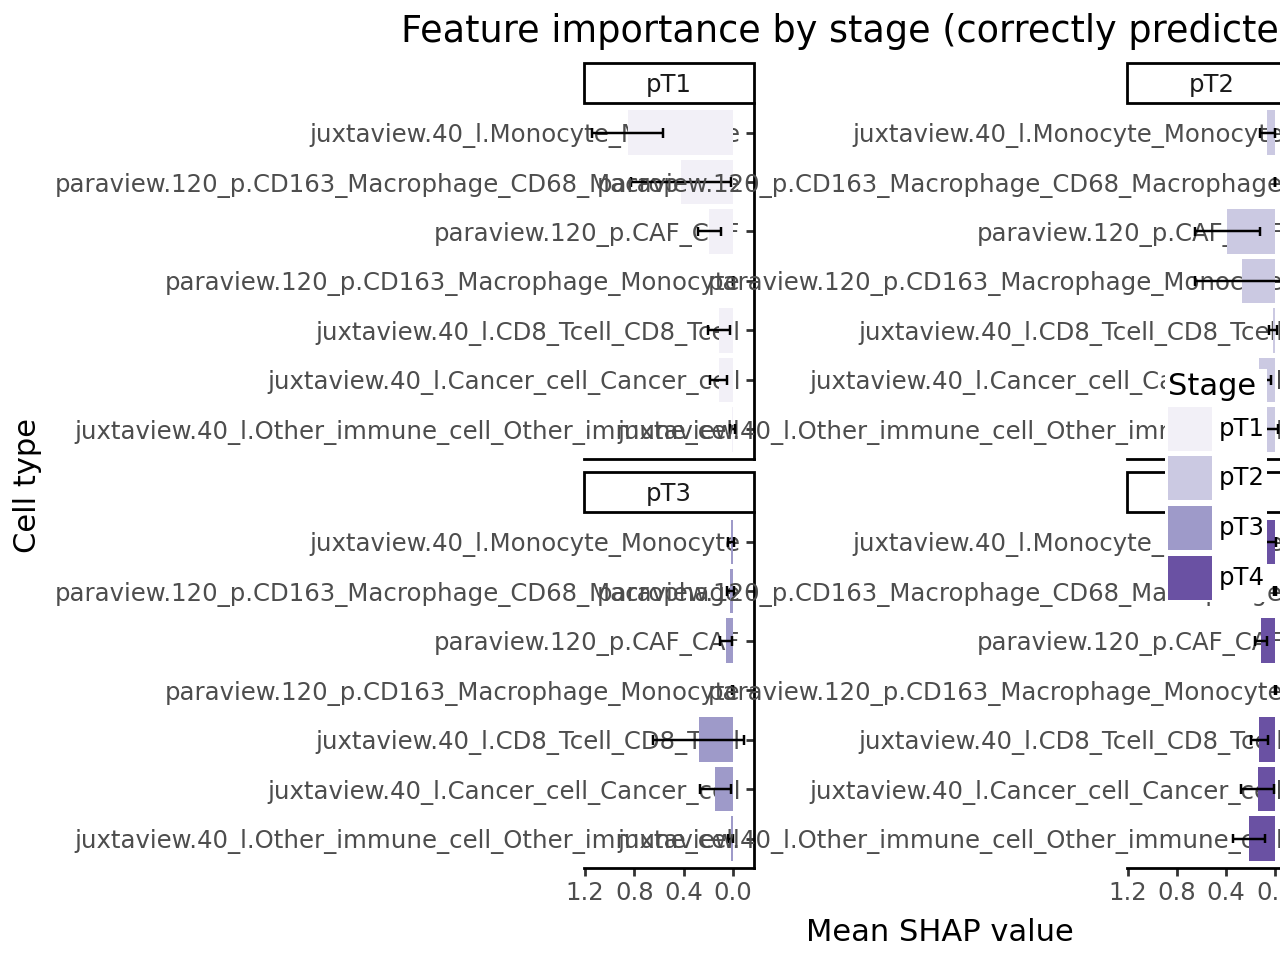

In [47]:
FT_PER_CLASS = 2 # Number of most important features kept per class

train_misty = misty_features.loc[meta_per_fov["inner"]]
original_stages = meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(original_stages)

xgb = XGBClassifier(
    n_estimators=35, 
    max_depth=7, 
    device="cuda", 
    random_state=0)
xgb.fit(train_misty,
        true_labels)

explainer = shap.Explainer(xgb)
shap_values = explainer(train_misty)

# Purples + Green for healthy
pal_stages = [(242,240,247), (203,201,226), (158,154,201), (106,81,163)]
# Convert to hex
pal_stages = ['#%02x%02x%02x' % (r, g, b) for r, g, b in pal_stages]

predicted_labels = xgb.predict(train_misty)
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)
# Few errors on training set, so not meaningful to interpret misclassified FOVs

# For each stage, see how the true positive samples were predicted (SHAP values)

# Get indices of correctly predicted samples for each class
correct_indices = {class_idx: np.where((true_labels == class_idx) & (predicted_labels == class_idx))[0] 
                   for class_idx in range(conf_matrix.shape[0])}

shap_values_list = []
for class_idx, indices in correct_indices.items():
    shap_values_class = pd.DataFrame(shap_values.values[indices, :, class_idx], 
                                     columns=train_misty.columns)
    shap_values_class['fov'] = train_misty.index[indices]
    shap_values_class['class'] = label_encoder.inverse_transform([class_idx])[0]  # Use original stage names
    shap_values_list.append(shap_values_class)

shap_values_df = pd.concat(shap_values_list)

# Melt the DataFrame for easier plotting with plotnine
shap_values_melted = shap_values_df.melt(id_vars=['fov', 'class'], var_name='Feature', value_name='SHAP Value')

# Compute mean and std SHAP values for feature importance for each class
feature_importance = shap_values_melted.groupby(['class', 'Feature'])['SHAP Value'].agg(['mean', 'std']).reset_index()
# We want to display either high positive or high negative values
feature_importance["abs_mean"] = np.abs(feature_importance["mean"]) 
feature_importance = feature_importance.sort_values(by=['class', 'abs_mean'], ascending=[True, False])

# Note: nothing enforces SHAP values to be positive, but in average they all seem to be

feature_importance = feature_importance.loc[feature_importance.Feature.isin(feature_importance.groupby('class').head(FT_PER_CLASS).Feature)]

# Add a column for reordering features
feature_importance['Feature'] = pd.Categorical(feature_importance['Feature'], 
                                               categories=feature_importance.groupby('class').head(FT_PER_CLASS).Feature.unique()[::-1], 
                                               ordered=True)
feature_importance['class'] = feature_importance['class'].astype('category')

# Step 8: Visualize feature importance using plotnine
gp = (ggplot(feature_importance, 
                aes(x='Feature', y='mean', fill='class'))
      + geom_bar(stat='identity', position='dodge')
      + geom_errorbar(aes(ymin='mean-0.5*std', ymax='mean+0.5*std'), width=0.2, position='dodge')
      + coord_flip()
      + theme_classic()
      + scale_fill_manual(values=pal_stages)
      + labs(title='Feature importance by stage (correctly predicted samples)', x='Cell type', y='Mean SHAP value', fill='Stage')
      + facet_wrap('~class', scales='free_y'))

ggsave(gp, "../../figures/fig4/misty_lineage_importance_correctly_predicted_samples.pdf", width=10, height=5)

gp.show()


In [48]:
ggsave(gp, "../../figures/fig4/misty_lineage_importance_correctly_predicted_samples.pdf", width=12, height=5)


/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 12 x 5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig4/misty_lineage_importance_correctly_predicted_samples.pdf


## Model 6: Kasumi metabolic features
See *KasumiColorectal.ipynb*. We note that training on the FOV-level associations rather than the cluster frequencies lead to better performance.

In [48]:
misty_features_raw = pd.read_csv("../../data/kasumi_metab_features.csv", index_col=0)
# Subset to top 100 most common features
misty_features = misty_features_raw.iloc[:,np.argsort(-np.sum(misty_features_raw > 0))[:100]]

In [49]:
# FOVs now exclude healthy samples
misty_features = misty_features.loc[meta_per_fov.index]

In [50]:
# Order is preserved
assert meta_per_fov.index.equals(misty_features.index)

In [51]:
def process_fold_misty(train, test, n_estimators = 250, n_depth = 4):
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    with warnings.catch_warnings(action="ignore"):
        # Step 1: Define train and test subsets of the MISTy data
        train_misty = misty_features.loc[meta_per_fov["inner"]].iloc[train]
        test_misty = misty_features.loc[meta_per_fov["inner"]].iloc[test]
        train_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"]
        test_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"]
        
        # Step 2: Train a classifier on the training data to predict the stage of each FOV
        xgb = XGBClassifier(
            n_estimators=n_estimators, 
            max_depth=n_depth, 
            device="cuda", 
            random_state=0)
        xgb.fit(train_misty,
                LabelEncoder().fit_transform(train_meta))
        
        # # Step 3: Predict stage of each FOV in the test data
        preds = xgb.predict(test_misty)

        # # Step 4: Compute f1_score
        score = f1_score(LabelEncoder().fit_transform(test_meta), 
                        preds, 
                        average="weighted")
        return score

In [52]:
def test_estimator_misty(estimators,depth):
    scores = [process_fold_misty(train, test, n_estimators=estimators, n_depth=depth)
              for train, test in cv_folds_fov]
    mean_score = np.median(scores)
    # Append to f1 score log file
    with open(f"../../data/model7_kasumi_marker_f1_scores.txt", "a") as f:
        f.write(f"{estimators},{depth},{mean_score}\n")
    
    print(estimators, mean_score)
    return mean_score

In [110]:
# Parallelize the hyperparameter loop | ~ 30mn
estimator_range = np.arange(15, 511, 10)
depth_range = np.arange(3, 10, 2)
estimator_range, depth_range = np.meshgrid(estimator_range, depth_range)
Parallel(n_jobs=28)(delayed(test_estimator_misty)(r_estimators, r_depth)
                for r_estimators, r_depth in zip(estimator_range.ravel(), depth_range.ravel()))

15 0.4216015381358762
25 0.4040238185213131
35 0.42022279598100964
45 0.4219157407758939
55 0.40404167110602335
65 0.3979568888962154
75 0.40877414872960505
85 0.40487500815178634
95 0.4052000776157623
105 0.40923736398668575
115 0.4101041787232368
125 0.40798760942782525
135 0.39927506917578504
145 0.4066542115371936
155 0.4066542115371936
165 0.397990413057869
175 0.3938126708018013
185 0.39396444925869467
195 0.39396444925869467
205 0.39424071350482637
215 0.39424071350482637
225 0.39424071350482637
235 0.39424071350482637
245 0.3900017115283404
15 0.40761807519483384
255 0.3900017115283404
265 0.3900017115283404
275 0.3855477050261411
25 0.3947397656999492
285 0.39242508468641213
35 0.3866508182057181
295 0.39242508468641213
45 0.39219003696223287
305 0.39242508468641213
55 0.3866734829965803
315 0.39242508468641213
65 0.38346154020278067
325 0.39242508468641213
75 0.39800033291089576
335 0.39205309542539823
85 0.39001755924034687
345 0.39205309542539823
95 0.3858831983296488
355 0

[0.4216015381358762,
 0.4040238185213131,
 0.42022279598100964,
 0.4219157407758939,
 0.40404167110602335,
 0.3979568888962154,
 0.40877414872960505,
 0.40487500815178634,
 0.4052000776157623,
 0.40923736398668575,
 0.4101041787232368,
 0.40798760942782525,
 0.39927506917578504,
 0.4066542115371936,
 0.4066542115371936,
 0.397990413057869,
 0.3938126708018013,
 0.39396444925869467,
 0.39396444925869467,
 0.39424071350482637,
 0.39424071350482637,
 0.39424071350482637,
 0.39424071350482637,
 0.3900017115283404,
 0.3900017115283404,
 0.3900017115283404,
 0.3855477050261411,
 0.39242508468641213,
 0.39242508468641213,
 0.39242508468641213,
 0.39242508468641213,
 0.39242508468641213,
 0.39205309542539823,
 0.39205309542539823,
 0.39205309542539823,
 0.39205309542539823,
 0.3909345233532031,
 0.39205309542539823,
 0.39205309542539823,
 0.3909345233532031,
 0.3909345233532031,
 0.3909345233532031,
 0.3909345233532031,
 0.3909345233532031,
 0.3909345233532031,
 0.3909345233532031,
 0.39003127

In [53]:
pd.read_csv("../../data/model7_kasumi_marker_f1_scores.txt", header=None, names=["estimators", "depth", "score"]).sort_values("score", ascending=False).head(10)

,estimators,depth,score
146,115,9,0.427298
148,125,9,0.423394
150,135,9,0.423394
154,155,9,0.423394
152,145,9,0.423394
157,165,9,0.423394
192,435,9,0.423174
193,445,9,0.423174
195,465,9,0.423174
198,495,9,0.423174


In [54]:
scores = [process_fold_misty(train, test, n_estimators=115, n_depth=9)
              for train, test in cv_folds_fov]
print(np.median(scores))

0.4272981448609179


In [55]:
# Add the model
all_models_inner = pd.concat([all_models_inner, 
                            pd.DataFrame({
                                "model": ["M6 spatial metabolism" for _ in enumerate(scores)],
                                "score": scores
                            })], ignore_index=True)

## Summary of models selection

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 11.2 x 5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig4/inner_f1_scores.pdf


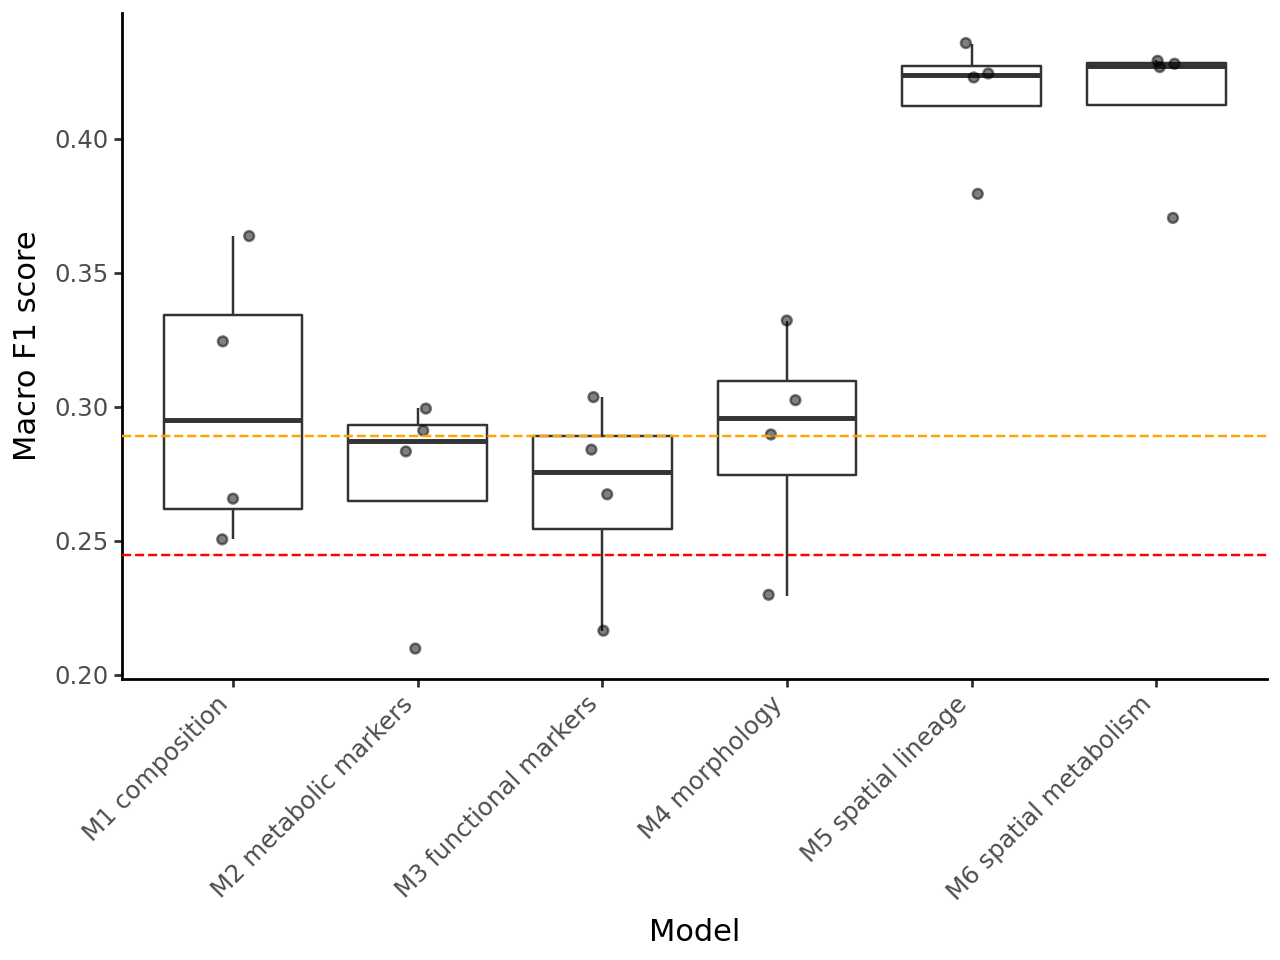

In [56]:
gp = (ggplot(all_models_inner, aes(x = "model", y = "score")) 
      + geom_boxplot(outlier_alpha = 0) 
      + geom_jitter(width = 0.1, alpha = 0.5)
      + theme_classic()
      + geom_hline(yintercept=np.median(np.median(all_f1_scores, axis = 0)), linetype="dashed", color="red")
      + geom_hline(yintercept=np.quantile(np.median(all_f1_scores, axis = 0), 0.95), linetype="dashed", color="orange")      
      + theme(axis_text_x = element_text(angle = 45, hjust = 1))
      + labs(x = "Model", y = "Macro F1 score")
)
ggsave(gp, "../../figures/fig4/inner_f1_scores.pdf", width=11.2, height=5)
gp.show()